# Laboratório Modulação Digital com Áudio / Valdemar Victor Leite Carvalho (123110796)

⚠️ Esse codigo não funciona em maquinas virtuais ou no WSL


Sobre esse Laboratório:

- [Setup](#setup)
- [Parametros e Bibliotecas](#parametros-de-configurações)
- [Funções e Metodos](#funções)
- [O Laboratório](#o-laboratório)
    1. [Etapa 2: Decodificação](#etapa-2-decodificação)
    1. [Etapa 3: Impacto do Ruído na Comunicação](#etapa-3-impacto-do-ruído-na-comunicação)
    1. [Etapa 4: Ruído Real](#etapa-4-decodificação-no-mundo-real)



## Setup

⚠️ **Atenção** : Execute o código abaixo **apenas uma vez** para realizar a configuração inicial do ambiente.

In [6]:
!pip install numpy matplotlib soundfile sounddevice scipy

Escolhendo a saida e entrada de audio

In [7]:
import os

import sounddevice as sd
import numpy as np
from scipy.io import wavfile

O comando `sd.query_devices()` listará todas as **entradas** e **saídas** de áudio disponíveis no seu computador. 

A partir dessa lista, identifiquei qual é a **entrada** (microfone) e **saída** (alto-falante) de áudio desejada e atribuirei esses valores às variáveis `input_device` e `output_device`, respectivamente. Por exemplo,

```
  0 sof-hda-dsp: - (hw:0,0), ALSA (2 in, 0 out)
  1 sof-hda-dsp: - (hw:0,3), ALSA (0 in, 2 out)
  2 sof-hda-dsp: - (hw:0,4), ALSA (0 in, 2 out)
  3 sof-hda-dsp: - (hw:0,5), ALSA (0 in, 2 out)
  4 sof-hda-dsp: - (hw:0,6), ALSA (2 in, 0 out)
  5 sof-hda-dsp: - (hw:0,7), ALSA (2 in, 0 out)
  6 sof-hda-dsp: - (hw:0,31), ALSA (0 in, 2 out)
  7 sysdefault, ALSA (128 in, 0 out)
  8 pipewire, ALSA (64 in, 64 out)
* 9 default, ALSA (64 in, 64 out)
```

Para que o laboratorio funcione adequamente no meu computador tive que escolher opcoes 10 , 10.

In [8]:
sd.query_devices()

  0 sof-hda-dsp: - (hw:0,0), ALSA (2 in, 0 out)
  1 sof-hda-dsp: - (hw:0,3), ALSA (0 in, 2 out)
  2 sof-hda-dsp: - (hw:0,4), ALSA (0 in, 2 out)
  3 sof-hda-dsp: - (hw:0,5), ALSA (0 in, 2 out)
  4 sof-hda-dsp: - (hw:0,6), ALSA (2 in, 0 out)
  5 sof-hda-dsp: - (hw:0,7), ALSA (2 in, 0 out)
  6 sof-hda-dsp: - (hw:0,31), ALSA (0 in, 2 out)
  7 sysdefault, ALSA (128 in, 0 out)
  8 pipewire, ALSA (64 in, 64 out)
* 9 default, ALSA (64 in, 64 out)

In [9]:
output_device = 9
input_device = 9
sd.default.device = (input_device, output_device)

🎯 Execute o código abaixo para gravar um áudio de 3 segundos e, em seguida, reproduzi-lo.

Caso a gravação ou reprodução não funcione corretamente, ajuste os valores das variáveis `input_device` (dispositivo de entrada) e `output_device` (dispositivo de saída) até que o código funcione como esperado.

In [10]:
DURATION = 3  # duraçao em segundos
SAMPLE_RATE = 44100  # Hz
FILENAME = "captura.wav"

audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
print("Gravação finalizada.")

# Salvando arquivo de audio temporario
max_val = np.max(np.abs(audio))
if max_val > 0:
    scaled = audio / max_val
else:
    scaled = audio
wav_data = np.int16(scaled * 32767)
wavfile.write(FILENAME, SAMPLE_RATE, wav_data)
print(f"Áudio salvo em {FILENAME}")

# Reproduz o áudio salvo
fs, data = wavfile.read(FILENAME)
sd.play(data, fs)
sd.wait()
os.remove(FILENAME)
print('Se você escutou o audio tudo seu sistema está configurado corretamente!')

Gravação finalizada.
Áudio salvo em captura.wav
Se você escutou o audio tudo seu sistema está configurado corretamente!


## Parâmetros de configurações

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import time
import os

Parâmetros de codificação

In [12]:
##
## Configurações globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (Lá)
FREQ_HIGH = 880      # bit '1' (Lá oitava)

## Funções

Nessa seção você encontrará as funções utilizadas

### Gerador de tom & visualização

In [13]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequência em Hz
        duration: Duração em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de áudio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transições
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [14]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [15]:
def plot_signal(audio_signal, title, num_bits):
    time_axis = np.linspace(0, len(audio_signal)/SAMPLE_RATE, len(audio_signal))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal)
    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    for i in range(1, num_bits): #divisões dos bits
        plt.axvline(x=i*BIT_DURATION, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Codificadores

In [16]:
def encode_nrz(data_bits,debug=False):
    """
    Codifica dados usando NRZ
    
    Args:
        data_bits: string de bits (ex: "10110")
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando NRZ: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            freq = FREQ_HIGH
            show(f"Bit {i}: '1' -> {freq} Hz",debug)
        else:
            freq = FREQ_LOW
            show(f"Bit {i}: '0' -> {freq} Hz",debug)
        
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])
    
    return audio_signal

In [17]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

### Decodificadores

In [18]:
def estimate_tone_freqs(x, sr):
    N = min(len(x), sr*10)
    X = np.abs(fft(x[:N])[:N//2])
    freqs = fftfreq(N, 1.0/sr)[:N//2]

    mask = (freqs > 300) & (freqs < sr/2 - 1000)
    freqs_masked = freqs[mask]
    X_masked = X[mask]

    peaks, _ = find_peaks(X_masked, distance=20)
    if len(peaks) < 2:
        idx = np.argsort(X_masked)[-2:]
    else:
        idx = peaks[np.argsort(X_masked[peaks])[-2:]]

    est = np.sort(freqs_masked[idx])
    return float(est[0]), float(est[1])

In [19]:
def short_time_tone_energy(x, sr, f, win_len=0.01, hop=0.002):
    nwin = int(win_len*sr)
    hopn = int(hop*sr)
    if nwin < 8: nwin = 8
    if hopn < 1: hopn = 1

    times = []
    energy = []

    t0 = 0
    while t0 + nwin <= len(x):
        w = x[t0:t0+nwin] * np.hanning(nwin)
        tt = np.arange(t0, t0+nwin) / sr
        s = np.sin(2*np.pi*f*tt)
        c = np.cos(2*np.pi*f*tt)
        e = (np.dot(w, s)**2 + np.dot(w, c)**2) / nwin

        energy.append(e)
        times.append((t0 + nwin/2)/sr)
        t0 += hopn

    return np.array(times), np.array(energy)

In [20]:
def decode_bits_from_symbol_series(times, symbol_vals, estimated_baud):
    bit_dur = 1.0 / estimated_baud
    t_start = times[0] - bit_dur * 0.5
    t_end = times[-1] + (times[1] - times[0]) * 0.5

    nb = int(np.floor((t_end - t_start) / bit_dur))
    bits = []
    bit_times = []

    for i in range(nb):
        bs = t_start + i * bit_dur
        be = bs + bit_dur
        mask = (times >= bs) & (times < be)

        if np.sum(mask) == 0:
            bits.append(0)
        else:
            bits.append(int(np.mean(symbol_vals[mask]) > 0.5))

        bit_times.append(bs + bit_dur/2)

    return np.array(bits), np.array(bit_times), bit_dur

In [21]:
def analyze_signal(x, sr, show_plots=True, title_suffix="", save_bin=True):
    x = x.astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-12)

    f0, f1 = estimate_tone_freqs(x, sr)

    t0, E0 = short_time_tone_energy(x, sr, f0)
    t1, E1 = short_time_tone_energy(x, sr, f1)

    times = t0
    diff = E1 - E0
    symbol = (diff > 0).astype(int)

    N = len(diff)
    sample_rate_st = 1.0/(times[1]-times[0])
    Y = np.abs(fft(diff - np.mean(diff)))
    freqs = fftfreq(N, 1.0/sample_rate_st)
    mask = (freqs > 0.5) & (freqs < sample_rate_st/2)

    if np.any(mask):
        idx = np.argmax(Y[mask])
        est_baud = max(1.0, round(freqs[mask][idx]))
    else:
        est_baud = 100.0

    bits, bit_times, bit_dur = decode_bits_from_symbol_series(times, symbol, est_baud)

    mid_checks = []
    for i, bt in enumerate(bit_times):
        bs = bt - bit_dur/2
        mid = bt
        be = bt + bit_dur/2

        mask_first = (times>=bs) & (times<mid)
        mask_second = (times>=mid) & (times<be)

        if np.sum(mask_first)==0 or np.sum(mask_second)==0:
            mid_checks.append(0)
            continue

        v_first = np.mean(symbol[mask_first])
        v_second = np.mean(symbol[mask_second])

        mid_checks.append(int(abs(v_first - v_second) > 0.4))

    mid_checks = np.array(mid_checks)
    encoding = "manchester" if np.mean(mid_checks) > 0.4 else "nrz"

In [22]:
def analyze_file(path):
    sr, x = wavfile.read(path)

    if x.ndim > 1:
        x = x.mean(axis=1)

    x = x.astype(np.float32)
    x /= np.max(np.abs(x)) + 1e-12

    f0, f1 = estimate_tone_freqs(x, sr)

    t0, E0 = short_time_tone_energy(x, sr, f0)
    t1, E1 = short_time_tone_energy(x, sr, f1)

    times = t0
    diff = E1 - E0
    symbols = (diff > 0).astype(int)

    N = len(diff)
    sample_rate_st = 1.0 / (times[1] - times[0])

    Y = np.abs(fft(diff - np.mean(diff)))
    freqs = fftfreq(N, 1.0/sample_rate_st)

    mask = (freqs > 0.5) & (freqs < sample_rate_st/2)

    if np.any(mask):
        idx = np.argmax(Y[mask])
        baud = max(1, round(freqs[mask][idx]))
    else:
        baud = 100  # fallback

    bits, bit_times, bit_dur = decode_bits_from_symbol_series(times, symbols, baud)

    mid_checks = []
    for i, bt in enumerate(bit_times):
        bs = bt - bit_dur/2
        mid = bt
        be = bt + bit_dur/2

        mask1 = (times >= bs) & (times < mid)
        mask2 = (times >= mid) & (times < be)

        if np.sum(mask1) == 0 or np.sum(mask2) == 0:
            mid_checks.append(0)
            continue

        avg1 = np.mean(symbols[mask1])
        avg2 = np.mean(symbols[mask2])

        mid_checks.append(int(abs(avg1 - avg2) > 0.4))

    encoding = "manchester" if np.mean(mid_checks) > 0.4 else "nrz"

    plt.figure(figsize=(10, 4))
    plt.step(times, symbols, where='mid')
    plt.title(f"Demodulated – {encoding.upper()}, bits={len(bits)}, baud={baud}")
    plt.xlabel("Time (s)")
    plt.ylabel("Symbol")
    plt.tight_layout()
    plt.show()

    bitstring = ''.join(str(b) for b in bits)

    print("\n----------- RESULTADOS -----------")
    print(f"Bits decodificados : {len(bits)}")
    print(f"Baud estimado      : {baud}")
    print(f"Codificação        : {encoding}")
    print(f"Mensagem (binário) : {bitstring}")

### Ruído

In [23]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

In [104]:
def decode_nrz(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZ
    
    Args:
        audio_signal: Sinal de áudio
        num_bits: Número esperado de bits
        sample_rate: Taxa de amostragem
    
    Returns:
        str: Bits decodificados
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando NRZ:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            show(f"Aviso: Áudio muito curto para {num_bits} bits",debug)
            break
        
        # Analisa o meio do bit para evitar transições
        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]
        
        freq = detect_frequency(segment, sample_rate)
        bit = frequency_to_bit(freq)
        decoded_bits += bit
        
        show(f"Bit {i}: freq={freq:.1f}Hz -> '{bit}'",debug)
    
    return decoded_bits

In [24]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

In [25]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

In [ ]:
def simular_erros_manchester(original_bits, modulação, snr_dB_faixa, num_testes=100):
    resultados_snr = []
    
    for snr_dB in snr_dB_faixa:
        erros_acumulados = 0
        
        for _ in range(num_testes):
            # Codificação
            clean_signal = encode_manchester(original_bits)
            
            # Ruídos
            noisy_signal = adicionar_ruido(clean_signal, snr_dB)
            
            # Decodificação
            decoded_bits = decode_manchester(noisy_signal, len(clean_signal))
            
            # Comparação
            decoded_bits_clean = decoded_bits.replace("?", "0")  
            decoded_arr = np.array([int(b) for b in decoded_bits_clean])
            original_arr = np.array([int(b) for b in original_bits])
            erros = np.sum(decoded_arr != original_arr)
            
            erros_acumulados += erros
            
        media_erros = erros_acumulados / num_testes
        resultados_snr.append((snr_dB, media_erros))
        
    return resultados_snr

In [140]:
def simular_erros_nrz(original_bits, modulação, snr_dB_faixa, num_testes=100):
    resultados_snr = []
    
    for snr_dB in snr_dB_faixa:
        erros_acumulados = 0
        
        for _ in range(num_testes):
            # Codificação
            clean_signal = encode_nrz(original_bits)
            
            # Ruídos
            noisy_signal = adicionar_ruido(clean_signal, snr_dB)
            
            # Decodificação
            decoded_bits = decode_nrz(noisy_signal, len(clean_signal))
            
            # Comparação
            decoded_bits_clean = decoded_bits.replace("?", "0")  
            decoded_arr = np.array([int(b) for b in decoded_bits_clean])
            original_arr = np.array([int(b) for b in original_bits])
            erros = np.sum(decoded_arr != original_arr)
            
            erros_acumulados += erros
            
        media_erros = erros_acumulados / num_testes
        resultados_snr.append((snr_dB, media_erros))
        
    return resultados_snr

### Captura e Simulação Real de Ruído

In [143]:
def capturar_do_microfone(duracao_segundos):
    """
    Captura áudio do microfone
    
    Args:
        duracao_segundos: Duração da captura
    
    Returns:
        array: Áudio capturado
    """
    print(f"Iniciando captura por {duracao_segundos} segundos...")
    print("Reproduza o áudio no seu celular AGORA!")
    
    # Captura áudio
    audio_capturado = sd.rec(
        int(duracao_segundos * SAMPLE_RATE), 
        samplerate=SAMPLE_RATE, 
        channels=1
    )
    sd.wait()  # Aguarda terminar a captura
    
    print("Captura concluída!")
    return audio_capturado.flatten()

## Etapa 2: Decodificação

Para decodificar corretamente, contei com a ajuda de Inteligência Artificial para gerar partes do código e me explicar como se dava uma decodificação independente, dado que a decodificação oferecida no laboratório estava decodificando ambos e deixando a análise mais difícil. Explicando:

O demodulador FSK usado em suas funções é configurado como um pipeline, onde cada estágio extrai uma porção das informações básicas até os bits finais. Tudo começa com a função `estimate_tone_freqs`, que encontra as duas frequências correspondentes aos valores dos bits “0” e “1” no FSK. Para isso, ela examina uma porção inicial do áudio, calcula seu espectro usando FFT e detecta os picos mais altos dentro de uma faixa de interesse. Esses picos são considerados as frequências portadoras FSK. Esta etapa é importante, pois sem saber quais frequências representam quais símbolos, nenhuma decodificação subsequente é possível.

Com as frequências determinadas, passamos para o sinal `short_time_tone_energy`, que calcula a energia em uma determinada frequência em diferentes momentos. Ele decompõe o sinal em pequenas janelas (10 ms por padrão) e, em seguida, aplica uma janela de suavização a cada segmento, projetando cada segmento como um seno e um cosseno da frequência. A soma dos quadrados dessas projeções é a energia desse tom nesse segmento. Este procedimento é realizado para ambas as frequências FSK, gerando dois vetores: a energia de f0 e a energia no domínio do tempo de f1. 

A diferença entre essas energias é então usada para determinar o símbolo FSK. É importante notar que, quando a energia em f1 é maior que a energia em f0, o símbolo transmitido é considerado um "1", caso contrário, o símbolo é um "0". Isso gera uma sequência temporal de símbolos ainda não alinhados no tempo, porque a duração exata de cada bit (baud) ainda não é conhecida (ao menos de forma independente, pois aqui no laboratório foi definido como 1 no setup).

A estimativa da taxa de símbolos é feita analisando o espectro da série temporal da energia diferencial. A função de análise observa que, se os símbolos mudam com periodicidade fixa, vai aparecer como um pico dominante na FFT da sequência de diferenças. O valor da frequência desse pico é arredondado e usado como baud estimado.

Agora já sabendo o baud, a função `decode_bits_from_symbol_series` pega os símbolos brutos e converte em bits reais, dividindo o tempo em janelas do tamanho de um bit e calculando a média dos símbolos dentro de cada janela. Se a média for maior que 0,5, o bit é definido como 1, se for menor, é 0. Isso corrige quaisquer distorções, reorganizando os dados no tempo e garante que cada bit tenha exatamente uma decisão associada a ele.

Depois dessa reconstrução, tem ainda a identificação automática do tipo de codificação utilizada, diferenciando entre NRZ e Manchester. Essa verificação compara a primeira metade de cada bit com a segunda: se existe praticamente sempre uma inversão entre elas, o padrão é classificado como Manchester. Se não há inversão consistente, o sinal é interpretado como NRZ.

A função `analyze_signal` engloba todas essas etapas: normaliza o áudio, estima as frequências FSK, calcula energias, obtém símbolos, estima o baud, reconstrói os bits e identifica a forma de codificação. A função `analyze_file` atua como uma interface direta para arquivos .wav: ela simplesmente lê o arquivo, converte-o para mono se necessário, executa a pipeline completa de análise e apresenta os resultados, como gráfico, bits decodificados, baud estimado e codificação detectada.

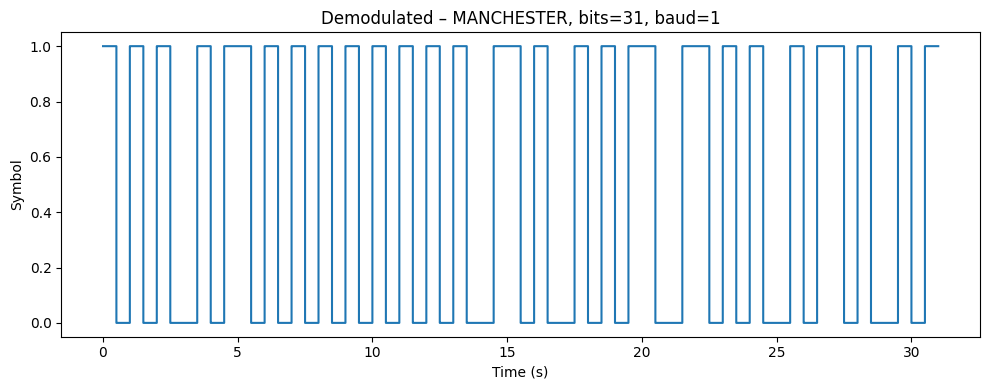


----------- RESULTADOS -----------
Bits decodificados : 31
Baud estimado      : 1
Codificação        : manchester
Mensagem (binário) : 1110110111100001100110111011000


In [26]:
analyze_file('dados_123110796_44100hz.wav')

#### Codificando Novamente para Confirmar a Mensagem Correta

Decodificando a partir do áudio original colocado, consegui o binário da mensagem. 

O proposto agora é fazer o processo reverso, codificar para confirmar se a mensagem está correta mesmo.

In [27]:
test_bits = "1110110111100001100110111011000"
print(f"Dados originais: {test_bits}\n")

Dados originais: 1110110111100001100110111011000



In [28]:
# Testa cada modulação
print("1. NRZ:")
nrz_signal = encode_nrz(test_bits,debug=True)

print("\n3. Manchester:")
manchester_signal = encode_manchester(test_bits,debug=True)

1. NRZ:
Codificando NRZ: 1110110111100001100110111011000
Bit 0: '1' -> 880 Hz
Bit 1: '1' -> 880 Hz
Bit 2: '1' -> 880 Hz
Bit 3: '0' -> 440 Hz
Bit 4: '1' -> 880 Hz
Bit 5: '1' -> 880 Hz
Bit 6: '0' -> 440 Hz
Bit 7: '1' -> 880 Hz
Bit 8: '1' -> 880 Hz
Bit 9: '1' -> 880 Hz
Bit 10: '1' -> 880 Hz
Bit 11: '0' -> 440 Hz
Bit 12: '0' -> 440 Hz
Bit 13: '0' -> 440 Hz
Bit 14: '0' -> 440 Hz
Bit 15: '1' -> 880 Hz
Bit 16: '1' -> 880 Hz
Bit 17: '0' -> 440 Hz
Bit 18: '0' -> 440 Hz
Bit 19: '1' -> 880 Hz
Bit 20: '1' -> 880 Hz
Bit 21: '0' -> 440 Hz
Bit 22: '1' -> 880 Hz
Bit 23: '1' -> 880 Hz
Bit 24: '1' -> 880 Hz
Bit 25: '0' -> 440 Hz
Bit 26: '1' -> 880 Hz
Bit 27: '1' -> 880 Hz
Bit 28: '0' -> 440 Hz
Bit 29: '0' -> 440 Hz
Bit 30: '0' -> 440 Hz

3. Manchester:
Codificando Manchester: 1110110111100001100110111011000
Bit 0: '1' -> 880Hz -> 440Hz
Bit 1: '1' -> 880Hz -> 440Hz
Bit 2: '1' -> 880Hz -> 440Hz
Bit 3: '0' -> 440Hz -> 880Hz
Bit 4: '1' -> 880Hz -> 440Hz
Bit 5: '1' -> 880Hz -> 440Hz
Bit 6: '0' -> 440Hz -> 88

**Escutando os dados:** como a nossa proposta é utilizar notas músicais (som) para representar `0` e `1`. É através delas que verificaremos o ritmo do aúdio. Nota-se que é possível escutar o Manchester com um ritmo muito mais rápido, dado que é característica dessa modularização, avaliar os bits enquanto a transição entre níveis é realizada.

In [29]:
sd.play(manchester_signal, SAMPLE_RATE)
sd.wait()

Enquanto ao codificar a mesma mensagem para NRZ, o ritmo é muito mais lento, dado que a avaliação só é feita após a transição e estabilização do nível. Portanto, ao escutar o **áudio original** anexado na atividade, percebemos que o Manchester fica idêntico, portanto podemos concluir também dessa forma, que a **codificação foi feita em Manchester**. 

In [30]:
sd.play(nrz_signal, SAMPLE_RATE)
sd.wait()

### Etapa 3: Impacto do Ruído na Comunicação

Simulação de decodificação em condições adversas, o método abaixo simula a adição de ruído ao sinal. Importante notar que nem sempre ruídos baixos afetam deterministicamente a decodificação.

Para adicionar ruído, fui testando valores **negativos** no `snr_db`.

Abaixo veja a mensagem original:

In [82]:
original_bits = "1110110111100001100110111011000"

#### Ruído com Manchester

Testando com Manchester, com snr igual a -26, a mensagem ainda permanece intacta

In [83]:
snr=-26

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 1110110111100001100110111011000
  Decodificado: 1110110111100001100110111011000
  Correto: True



A partir de srn -27, o ruído começa a alterar os bits

In [85]:
snr=-27

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 1110110111100001100110111011000
  Decodificado: 1110110?11100001100110111011000
  Correto: False



A partir do srn -37, todos os bits são comprometidos

In [86]:
snr=-37

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 1110110111100001100110111011000
  Decodificado: ???????????????????????????????
  Correto: False



Agora necessitamos plotar o gráfico para ter noção comparativa da evolução dos erros nessa execução específica.

Para tal, fiz a função específica de cada modulação, na qual um acumulador de erros é incrementado ao perceber "?" a cada decremento no snr, adicionando mais ruído a cada passo no loop. É possível perceber o que foi observado acima, com os erros iniciando a partir do -27 e atigindo seu ápice no -40. Dado que por não ser completamente determinístico, a média dos erros alcançados com o ruído, pode variar.

In [99]:
snr_range = np.linspace(-40, 0, 10)
resultados_manchester = simular_erros_manchester(original_bits, 'Manchester', snr_range)

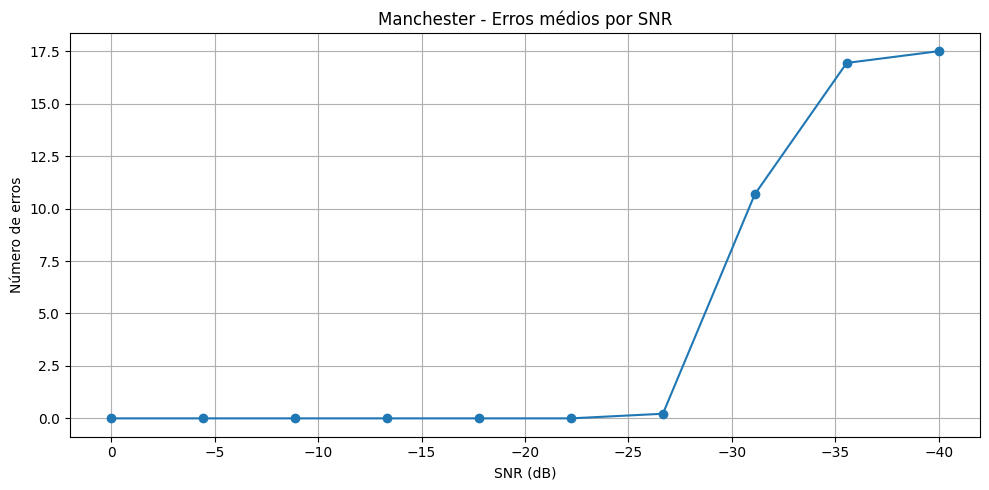

In [100]:
snr_vals = [item[0] for item in resultados_manchester]
erros_vals = [item[1] for item in resultados_manchester]

plt.figure(figsize=(10,5))
plt.plot(snr_vals, erros_vals, marker='o')
plt.gca().invert_xaxis() 
plt.title("Manchester - Erros médios por SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Número de erros")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Ruído com NRZ

A partir do snr -30, os bits começam a serem comprometidos

In [131]:
snr=-30

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 1110110111100001100110111011000
  Decodificado: 1110111111100001100110111011000
  Correto: False



Ao chegar no snr -39, os bits são completamente afetados

In [138]:
snr=-39

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 1110110111100001100110111011000
  Decodificado: 1111111111111111101111111111111
  Correto: False



In [141]:
snr_range = np.linspace(-40, 0, 10)
resultados_nrz = simular_erros_nrz(original_bits, 'NRZ', snr_range)

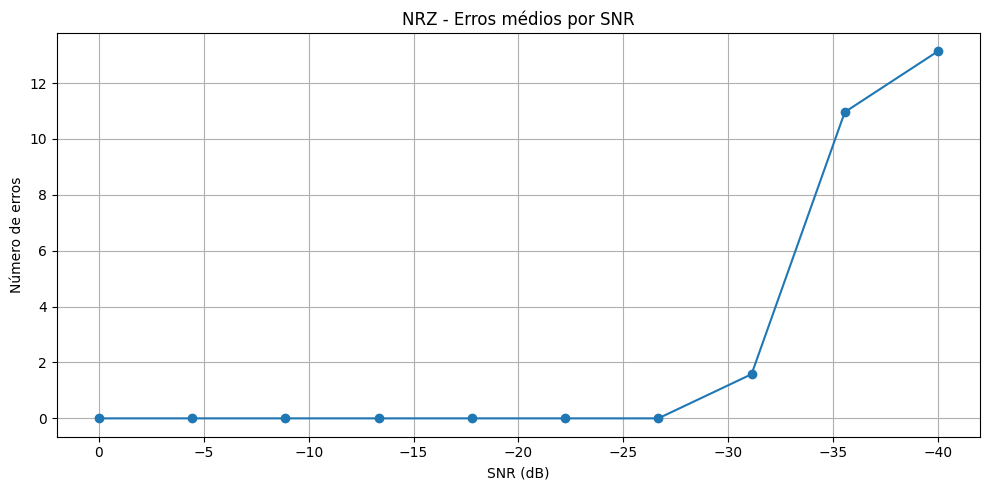

In [142]:
snr_vals = [item[0] for item in resultados_nrz]
erros_vals = [item[1] for item in resultados_nrz]

plt.figure(figsize=(10,5))
plt.plot(snr_vals, erros_vals, marker='o')
plt.gca().invert_xaxis() 
plt.title("NRZ - Erros médios por SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Número de erros")
plt.grid(True)
plt.tight_layout()
plt.show()


### Etapa 4: Decodificação no mundo real

Para este exercício, você utilizei um **segundo dispositivo**, como por exemplo, seu **celular**.

1. Copie o arquivo de áudio [dados_ar.wav](./dados_ar.wav) para o segundo dispositivo.
2. Este áudio contém uma **mensagem de 5 bits**, codificada utilizando o esquema **Manchester**.
3. O desafio consiste em **decodificar essa mensagem utilizando apenas o microfone do seu computador**.  
   **Não abra o arquivo diretamente** no computador — apenas reproduza o áudio no segundo dispositivo.

> 🧪 Certifique-se de que os [procedimentos de configuração](#setup) foram seguidos corretamente e que o microfone do seu computador está funcionando adequadamente.

Por fim, **executei o código abaixo** (referente à etapa de escuta por microfone) e reproduzi o áudio no segundo dispositivo para tentar decodificar a mensagem.

In [158]:
# test_data = "10110"
# Captura áudio

duracao = 5 * BIT_DURATION + 1  # +1 segundo de margem
audio_capturado = capturar_do_microfone(duracao)

# Salva captura para análise
sf.write('captura_microfone.wav', audio_capturado, SAMPLE_RATE)

# Tenta decodificar
print("\nTentando decodificar...")
decoded = decode_manchester(audio_capturado, 5)

print(f"Original: ?????")
print(f"Capturado: {decoded}")

Iniciando captura por 6.0 segundos...
Reproduza o áudio no seu celular AGORA!
Captura concluída!

Tentando decodificar...
Original: ?????
Capturado: 10110
